# Notebook 3: Photo-Z regression calculator

This notebook calculates a regression fit for photometric redshifts of galaxies. It uses the following steps:

- Queries a training set of galaxies for which redshifts are available (redshift is a rough measure of the distance to a galaxy).
- Derives a k-nearest-neighbour regressor that determines a redshift estimate from 5 "broad-band" magnitudes
- Tests the derived regressor against a test dataset by plotting actual redshifts of galaxies in the test set against redshifts predicted by the regressor.

Author: Jake VanderPlas (vanderplas@astro.washington.edu)

License: BSD

The figure is an example from astroML: see http://astroml.github.com

Modified to work with SDSS data by Dmitry Medvedev (dmedv@jhu.edu)

In [2]:
# Step 1: as usual, get token and make it available as 
#     a system variable for this session.
#   The token must be replaced with new one once it has 
#     expired, so you may need to run this block again.
with open('/home/idies/keystone.token', 'r') as f:
    token = f.read().rstrip('\n')# replace with your own token ID
import sys
sys.argv.append("--ident="+token)
# The token is now available as a system variable called "XXXXXXXX"

In [3]:
import SciServer.CasJobs as CasJobs   # work with CasJobs
from io import StringIO   # work with strings
import numpy as np   # standard Python math package
import pandas   # "pandas" package for data processing
from matplotlib import pyplot as plt   # plotting
from sklearn.neighbors import KNeighborsRegressor   # find regressor
from astroML.plotting import scatter_contour   # make scatterplot

In [3]:
# some special settings
# ensure columns get written completely in notebook
pandas.set_option('display.max_colwidth', -1)
# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')

In [4]:
NOBJECTS = 20000
GAL_COLORS_DTYPE = [('u', float),
                    ('g', float),
                    ('r', float),
                    ('i', float),
                    ('z', float),
                    ('redshift', float),
                    ('redshift_err', float)]

Now we do this

In [5]:
# get data from CasJobs
query_text = ('\n'.join(
    ("SELECT TOP %i" % NOBJECTS,
    "   p.u, p.g, p.r, p.i, p.z, s.z, s.zerr",
    "FROM PhotoObj AS p",
    "   JOIN SpecObj AS s ON s.bestobjid = p.objid",
    "WHERE ",
    "   p.u BETWEEN 0 AND 19.6",
    "   AND p.g BETWEEN 0 AND 20",
    "   AND (s.class = 'GALAXY' OR s.class = 'QSO')")))
response = CasJobs.executeQuery(query_text, "DR12", token = token)
# read the result as a
output = StringIO(response.read().decode())
data = np.loadtxt(output, delimiter=',',skiprows=1, dtype=GAL_COLORS_DTYPE)

executeQuery POST response:  200 OK


In [6]:
# show some of the data
print(data[1:10])

[ (19.50771, 17.58796, 16.61911, 16.15772, 15.84043, 0.09494177, 1.315234e-05)
 (19.11732, 17.15754, 16.09585, 15.61398, 15.24157, 0.1148384, 2.056456e-05)
 (19.23904, 17.18665, 16.14616, 15.7115, 15.27712, 0.09135894, 1.521454e-05)
 (19.476, 17.466, 16.45814, 16.00689, 15.63121, 0.09640553, 1.426369e-05)
 (19.49722, 17.53199, 16.54039, 16.1251, 15.80431, 0.09695929, 1.246576e-05)
 (19.37358, 17.33834, 16.35108, 15.91889, 15.58481, 0.1019636, 1.438762e-05)
 (19.04837, 17.03156, 16.07271, 15.62632, 15.3128, 0.1015565, 1.566082e-05)
 (18.97821, 17.07366, 16.13625, 15.65121, 15.34174, 0.06836177, 1.32015e-05)
 (19.00721, 17.09096, 16.17937, 15.73111, 15.4603, 0.09046934, 1.492269e-05)]


In [9]:
n_neighbors = 1

N = len(data)

# shuffle data
np.random.seed(0)
np.random.shuffle(data)

# put colors in a matrix
X = np.zeros((N, 4))
X[:, 0] = data['u'] - data['g']
X[:, 1] = data['g'] - data['r']
X[:, 2] = data['r'] - data['i']
X[:, 3] = data['i'] - data['z']
z = data['redshift']

# divide into training and testing data
Ntrain = N / 2
Xtrain = X[:Ntrain]
ztrain = z[:Ntrain]

Xtest = X[Ntrain:]
ztest = z[Ntrain:]

knn = KNeighborsRegressor(n_neighbors, weights='uniform')
zpred = knn.fit(Xtrain, ztrain).predict(Xtest)

rms = np.sqrt(np.mean((ztest - zpred) ** 2))
print("RMS error = %.2g" % rms)

RMS error = 0.34


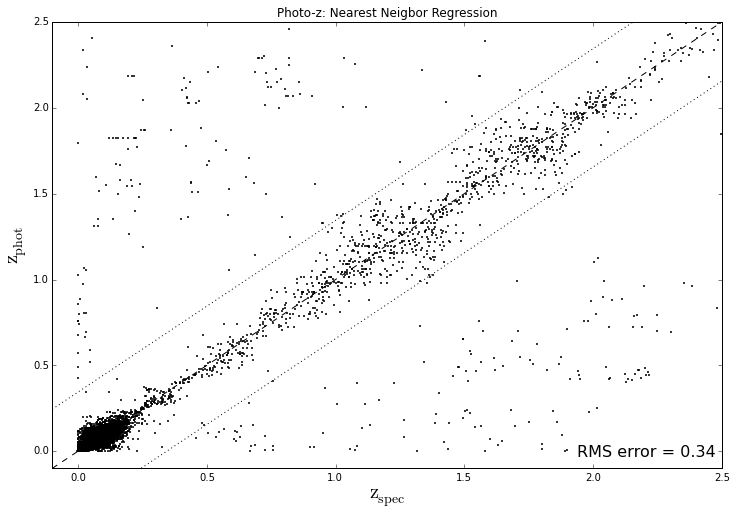

In [10]:
axis_lim = np.array([-0.1, 2.5])

plt.figure(figsize=(12, 8))
ax = plt.axes()
plt.scatter(ztest, zpred, c='k', lw=0, s=4)
plt.plot(axis_lim, axis_lim, '--k')
plt.plot(axis_lim, axis_lim + rms, ':k')
plt.plot(axis_lim, axis_lim - rms, ':k')
plt.xlim(axis_lim)
plt.ylim(axis_lim)

plt.text(0.99, 0.02, "RMS error = %.2g" % rms,
         ha='right', va='bottom', transform=ax.transAxes,
         bbox=dict(ec='w', fc='w'), fontsize=16)

plt.title('Photo-z: Nearest Neigbor Regression')
plt.xlabel(r'$\mathrm{z_{spec}}$', fontsize=20)
plt.ylabel(r'$\mathrm{z_{phot}}$', fontsize=20)
plt.show()